## Santa Fe Fireshed
### Output figure generation


In [3]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ---- Geospatial utilities
from geoUtils import *
from NECN_utils import *


### We need to build the framework for plots to be generated from
This generally means listing the names of simulations, or pointing to directories that hold the data that we need to access the info from specific sim, etc. This will ultimately turn into a more complicated list of different climates and treatment combinations, allowing us to ack more questions, with greater confidence.

In [21]:
testingSims = ['ExtremeFW_HistoricClimate_Sims']
mgmtSims = ['SFF_CNRM_Projected_PrioritizedMgmt']
nullSims = ['SFF_CNRM_Projected_NoMan']

### Mean and variance of fire severity
Processed by taking the stacks of fire severity rasters and calculating a mean across them. Here, consistent with previous work, the means are only for cells that burn, creating a description of what the mean severity of a grid cell is, should it burn.

Likewise, the variance raster only takes into account the variance of fire severity for a given grid cell, when that grid cell burns.

In [1]:
SFF_Sims = 'V:/ExtremeFW_HistoricClimate_Sims/'
    
sevmaps_mu = []
sevmaps_var = []

sevrasters = severityStack(SFF_Sims, 100)
sevMap, sevVarMap = severityGen(sevrasters)
sevmap = {SFF_Sims : sevMap}
sevVarmap = {SFF_Sims : sevVarMap}

sevmaps_mu.append(sevmap)
sevmaps_var.append(sevVarmap)

:0: FutureWarning: IPython widgets are experimental and may change in the future.
C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
NECN_utils.py:232: RuntimeWarning: Mean of empty slice
  meanSev = np.nanmean(rasterAdj, axis = 2)
NECN_utils.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varSev = np.nanvar(rasterAdj, axis = 2)


#### And the resulting figures

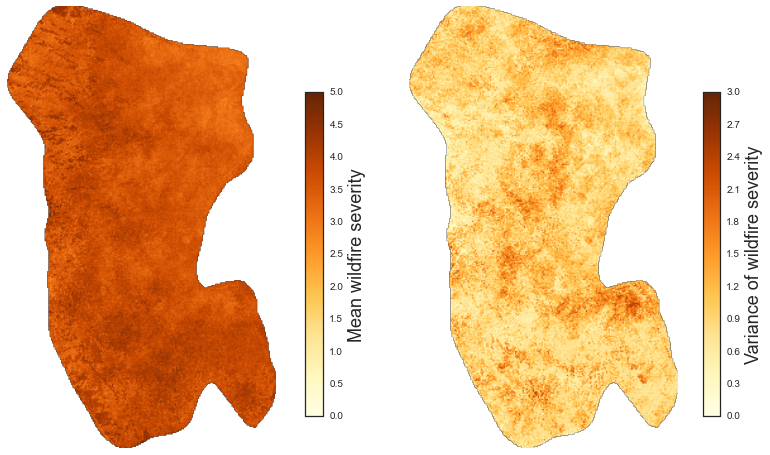

In [7]:
f, (ax, ax1) = plt.subplots(1,2, figsize =(12,10))
plt.subplots_adjust(wspace = 0.5)
plotRaster(sevmaps_mu[0][SFF_Sims], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax)
plotRaster(sevmaps_var[0][SFF_Sims], cmap = 'YlOrBr', vmin = 0, vmax = 5, ax = ax1)

cbarmapmu = ax.imshow(sevmaps_mu[0][SFF_Sims],   cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmapvar = ax1.imshow(sevmaps_var[0][SFF_Sims], cmap = 'YlOrBr', vmin = 0, vmax = 3)

cbar_ax1 = f.add_axes([0.93, 0.25, 0.02, 0.45])
cbar_ax = f.add_axes([0.47, 0.25, 0.02, 0.45])

kk =  f.colorbar(cbarmapmu, cax=cbar_ax,  label = 'Mean wildfire severity')
kk1 = f.colorbar(cbarmapvar, cax=cbar_ax1, label = 'Variance of wildfire severity')

axCB = kk.ax
axCB1 = kk1.ax

text = axCB.yaxis.label
text1 = axCB1.yaxis.label

text.set_fontsize(18)
text1.set_fontsize(18)
sns.set_style('white')

### The next fire output we can produce requires the fire logs
We can summarize a lot of info from the fire logs, like fire size distributions by mean fire severity, fire frequency, and some info about cohorts killed etc.

In [37]:
dffsLog = 'dynamic-fire-test-log.csv'
counter = 0
for simname in testingSims:
    reps = next(os.walk(SFF_Sims))[1]
    num_replicates = len(reps)

    for rep in reps:
        wkDir_c = SFF_Sims + rep + '/'
        repnum = rep.split('replicate')[1]
        if counter == 0:
            flogTot = pd.read_csv(wkDir_c + dffsLog)
            flogTot['SIM'] = simname
            flogTot['REP'] = repnum
        else:           
            flog = pd.read_csv(wkDir_c + dffsLog)
            flog['SIM'] = simname
            flog['REP'] = repnum
            flogTot = pd.concat([flogTot, flog])
        counter = counter + 1

flogTot[flogTot.TotalSitesInEvent <= 0].TotalSitesInEvent = np.nan
flogTot = flogTot.dropna()

### We can look at the mean replicate fire size by fire region
which is a rough approximation of the vegetation and fuels classes

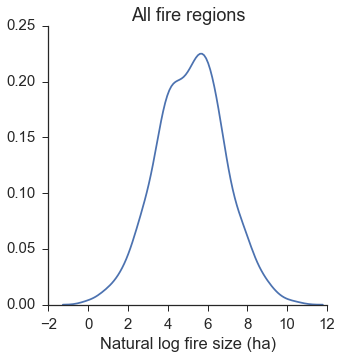

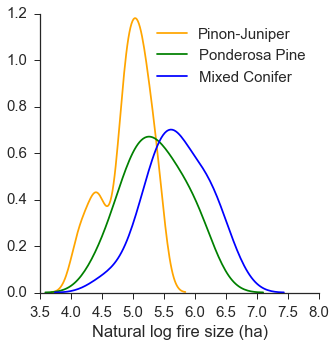

In [83]:
flogTotMu = flogTot.groupby('REP').mean()
f, (ax1) = plt.subplots(1,1, figsize =(5,5))
sns.distplot(np.log(flogTot.TotalSitesInEvent), 
             hist = False, kde = True, 
             hist_kws={"linewidth": 2,
                         "alpha": 1, "color": "gray"},
             bins = 10, ax = ax1)
ax1.set_xlabel('Natural log fire size (ha)')
ax1.set_title('All fire regions')
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)

flogTotMu = flogTot.groupby('REP').mean()
f, (ax1) = plt.subplots(1,1, figsize =(5,5))
sns.distplot(np.log(flogTotMu['eco-200']), 
             hist = False, kde = True,
             color = 'orange',
             bins = 10, ax = ax1, label = 'Pinon-Juniper')

sns.distplot(np.log(flogTotMu['eco-300']), 
             hist = False, kde = True,
             color = 'green',
             bins = 10, ax = ax1, label = 'Ponderosa Pine')

sns.distplot(np.log(flogTotMu['eco-400']), 
             hist = False, kde = True,
             color = 'blue',
             bins = 10, ax = ax1, label = 'Mixed Conifer')
ax1.set_xlim([3.5,8])
ax1.legend(loc = 0)
ax1.set_xlabel('Natural log fire size (ha)')
sns.despine()
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)

#### We can also ask questions about
how treatment affected fire size distributions in early, mid, or late century, which might be a useful thing to look at given the increasing fire weather severity in the simulations.

### We can do a lot with the Biomass rasters
The easiest thing to do is stack them up, and produce means and variances of biomass. by treatment, through time. We will look at early, mid, and late century biomass, aggregated by ecoregion, forest type, and the entire fireshed. 

The second step in looking at the biomass data is create ecoregion spatial sums and variances for time series display.